# Import libraries & settings

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

import shutil

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

In [2]:
# Settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
# Path to root folder
dir_path = 'C:/Users/Adam/Documents/Out of the Park Developments/OOTP Baseball 25/saved_games/'

# Destination folder for processed game logs
destination_folder_pitchers = 'C:/Users/Adam/Desktop/OOTP/Pitchers_historical_logs'
destination_folder_batters = 'C:/Users/Adam/Desktop/OOTP/Batters_historical_logs'

# Destination folder for final data sets
destination_folder = 'C:/Users/Adam/Desktop/OOTP'

# Import and process logs

In [4]:
# Import HTML files
html_files = []

for root, dirs, files in os.walk(dir_path):
    if 'html' in dirs:
        temp_dir = os.path.join(root, 'html')
        if 'temp' in os.listdir(temp_dir):
            html_dir = os.path.join(temp_dir, 'temp')
            for file in os.listdir(html_dir):
                if file.endswith('.html'):
                    html_files.append(os.path.join(html_dir, file))
# statistics_player_statistics_-_sortable_stats_batters.csv

In [5]:
# Load the parquet "DBs" into a Pandas DataFrame
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# feather was impossible to set up
df_pitchers = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

In [6]:
# ETL for new logs

for file in tqdm(html_files):
    # Reading the HTML file into a pandas DataFrame
    df = pd.read_html(file, flavor = 'bs4', skiprows=[0])[0]
    
    df = df.drop(0)
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    duplicate_cols = df.columns[df.columns.duplicated()]

    # Get a boolean mask indicating which column names are duplicates
    dupe_mask = df.columns.duplicated()

    # Add a suffix to duplicate column names
    df.columns = df.columns.where(~dupe_mask, df.columns + '_other')

    # Add column with timestamp (file name)
    # To be used to filter out old logs
    base_name = os.path.basename(file)
    file_name, file_extension = os.path.splitext(base_name)
    df['file_name'] = file_name
    
    # Concatenate the DataFrames for pitchers and batters independently
    if df.columns[6] == "STU":
        df_pitchers = pd.concat([df_pitchers, df])
        # Move
        shutil.move(file, destination_folder_pitchers)
    else:
        # Drop first column for batters
        #df = df.drop(df.columns[0], axis=1)
        df_batters = pd.concat([df_batters, df])
        shutil.move(file, destination_folder_batters)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:51<00:00, 85.54s/it]


In [7]:
# # name unification
# df_pitchers.loc[(df_pitchers['ORG'] == 'Fogtown Stars TBD'),'ORG'] ='Fogtown Stars'
# df_batters.loc[(df_batters['ORG'] == 'Fogtown Stars TBD'),'ORG'] ='Fogtown Stars'

# # Overwrite of wrong positions
# df_batters.loc[(df_batters['ORG'] == 'Fogtown Stars') & (df_batters['Name'] == 'Evan Gattis'),'POS'] ='C'	

In [8]:
# Store unaggregated data between sessions in parquet file
df_pitchers.astype(str).to_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters.astype(str).to_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

# Prepare Dataframes

In [9]:
# Filter out old games
df_pitchers = df_pitchers[df_pitchers['file_name'] > '2024-05-01']
df_batters = df_batters[df_batters['file_name'] > '2024-05-01']

In [10]:
# df_batters[(df_batters['ORG'] == 'Fogtown Stars') &(df_batters['POS'] == 'C') & (df_batters['Name'] == 'Evan Gattis')][['wRC','RC','wOBA','TB','H','AB','BB']]

## Data Types

### Pitchers

In [11]:
pitchers_data_types = {
                "POS": str, "Name": str, "ORG": str, "B": str, "T": str, "OVR": int, "STU": int,
                "MOV": int, "CON": int, "PBABIP": int, "HRR": int, "STU vL": int, "MOV vL": int,
                "CON vL": int, "PBABIP vL": int, "HRR vL": int, "STU vR": int, "MOV vR": int,
                "CON vR": int, "PBABIP vR": int, "HRR vR": int, "FB": int, "CH": int, "CB": int,
                "SL": int, "SI": int, "SP": int, "CT": int, "FO": int, "CC": int, "SC": int,
                "KC": int, "KN": int, "PIT": int, "G/F": str, "VELO": str, "Slot": str, "PT": str,
                "STM": int, "HLD": int, "IF RNG": int, "IF ERR": int, "IF ARM": int, "P": int,
                "G": int, "GS": int, "W": int, "L": int, "WIN%": float, "SVO": int, "SV": int,
                "SV%": float, "BS": int, "BS%": float, "HLD_other": int, "SD": int, "MD": int,
                "IP": float, "BF": int, "AB": int, "HA": int, "1B": int, "2B": int, "3B": int,
                "HR": int, "TB": int, "R": int, "ER": int, "BB": int, "IBB": int, "K": int,
                "HP": int, "ERA": float, "AVG": float, "OBP": float, "SLG": float, "OPS": float,
                "BABIP": float, "WHIP": float, "RA/9": float, "HR/9": float, "H/9": float,
                "BB/9": float, "K/9": float, "K/BB": float, "K%": float, "BB%": float,
                "K%-BB%": float, "SH": int, "SF": int, "WP": int, "BK": int, "CI": int, "DP": int,
                "RA": int, "GF": int, "IR": int, "IRS": int, "IRS%": float, "LOB%": float,
                "pLi": float, "GF%": float, "QS": int, "QS%": float, "CG": int, "CG%": float,
                "SHO": int, "PPG": int, "RS": int, "RSG": float, "PI": int, "GB": int,
                "FB_other": int, "GO%": float, "SB": int, "CS": int, "ERA+": int, "FIP": float,
                "FIP-": float, "WPA": float, "WAR": float, "rWAR": float, "SIERA": float,
                "TC": int, "A": int, "PO": int, "E": int, "DP_other": int, "TP": int, "PCT": float,
                "RNG": float, "ZR": float, "EFF": float}

In [12]:
for col, dtype in pitchers_data_types.items():
    if df_pitchers[col].dtype != dtype and dtype != 'str':
        df_pitchers[col] = df_pitchers[col].replace('-', 0)
        #df_pitchers[col] = pd.to_numeric(df_pitchers[col], errors='coerce').astype(dtype)
        df_pitchers[col] = df_pitchers[col].astype(dtype, errors = 'ignore')
        

In [13]:
df_pitchers = df_pitchers.convert_dtypes().reset_index(drop=True)
df_pitchers['VELO'] = df_pitchers['VELO'].str.split('-').str[0]

In [14]:
# decimal format of innings pitched 
df_pitchers['IP'] = df_pitchers['IP'].apply(lambda x: int(x) + (x % 1 * 10) / 3)

### Batters

In [15]:
batters_data_types = {'POS': str, 'Name': str, 'ORG': str, 'HT': str, 'B': str, 'T': str, 'OVR': int, 
                'BABIP': int, 'CON': int, 'GAP': int, 'POW': int, 'EYE': int, 'K\'s': int, 'BA vL': int, 
                'CON vL': int, 'GAP vL': int, 'POW vL': int, 'EYE vL': int, 'K vL': int, 'BA vR': int, 
                'CON vR': int, 'GAP vR': int, 'POW vR': int, 'EYE vR': int, 'K vR': int, 'BUN': int, 'BFH': int, 
                'BBT': str, 'GBT': str, 'FBT': str, 'C ABI': int, 'C ARM': int, 'IF RNG': int, 'IF ERR': int, 
                'IF ARM': int, 'TDP': int, 'OF RNG': int, 'OF ERR': int, 'OF ARM': int, 'DEF': int, 'P': int, 
                'C': int, '1B': int, '2B': int, '3B': int, 'SS': int, 'LF': int, 'CF': int, 'RF': int, 'SPE': int, 'SR': int, 
                'STE': int, 'RUN': int, 'G': int, 'GS': int, 'PA': int, 'AB': int, 'H': int, '1B_other': int, 
                '2B_other': int, '3B_other': int, 'HR': int, 'RBI': int, 'R': int, 'BB': int, 'BB%': float, 'IBB': int, 
                'HP': int, 'SH': int, 'SF': int, 'CI': int, 'SO': int, 'SO%': float, 'GIDP': int, 'EBH': int, 'TB': int, 
                'AVG': float, 'OBP': float, 'SLG': float, 'RC': float, 'RC/27': float, 'ISO': float, 'wOBA': float, 'OPS': float,  
                'OPS+': int, 'BABIP_other': float, 'WPA': float, 'wRC': int, 'wRC+': int, 'wRAA': float, 'WAR': float, 
                'PI/PA': float, 'SB': int, 'CS': int, 'SB%': float, 'BatR': float, 'wSB': float, 'UBR': float, 'BsR': float, 
                'G_other': int, 'GS_other': int, 'TC': int, 'A': int, 'PO': int, 'E': int, 'DP': int, 'TP': int, 
                'PCT': float, 'RNG': float, 'ZR': float, 'EFF': float, 'SBA': int, 'RTO': int, 'RTO%': float, 'IP': float, 
                'PB': int, 'CER': int, 'CERA': float, 'BIZ-R%': float, 'BIZ-R': int, 'BIZ-Rm': int, 'BIZ-L%': float, 
                'BIZ-L': int, 'BIZ-Lm': int, 'BIZ-E%': float, 'BIZ-E': int, 'BIZ-Em': int, 'BIZ-U%': float, 
                'BIZ-U': int, 'BIZ-Um': int, 'BIZ-Z%': float, 'BIZ-Z': int, 'BIZ-Zm': int, 'BIZ-I': int, 'FRM': float, 
                'ARM': float, 'BF%': float}


In [16]:
df_batters['GS'].fillna('0', inplace=True)
df_batters['GS'].replace({None: '0'}, inplace=True)
df_batters['GS'].replace({'nan': '0'}, inplace=True)
df_batters['G'].fillna('0', inplace=True)
df_batters['G'].replace({None: '0'}, inplace=True)
df_batters['G'].replace({'nan': '0'}, inplace=True)

In [17]:
for col, dtype in batters_data_types.items():
    if df_batters[col].dtype != dtype and dtype != 'str':
        df_batters[col] = df_batters[col].replace('-', 0)
        #df_batters[col] = pd.to_numeric(df_batters[col], errors='coerce').astype(dtype)
        if col in ['BIZ-R%', 'BIZ-L%', 'BIZ-E%', 'BIZ-U%', 'BIZ-Z%', 'BF%']:
            df_batters[col] = df_batters[col].str.replace('%', '')
        df_batters[col] = df_batters[col].astype(dtype, errors = 'ignore')

In [18]:
df_batters = df_batters.convert_dtypes().reset_index(drop=True)

### wRC calculation

In [19]:
#### wRC = (((wOBA-League wOBA)/wOBA Scale)+(League R/PA))*PA
# wRC / PA = ((wOBA-League wOBA)/wOBA Scale)+(League R/PA)
# (wRC / PA) - (League R/PA) = (wOBA-League wOBA)/wOBA Scale
# wOBA Scale = (wOBA-League wOBA)/((wRC / PA) - (League R/PA))

In [20]:
scaler_temp = df_batters[df_batters['wRC'] > 5][['wOBA','wRC','PA']]
scaler_temp['scaler'] = (scaler_temp['wOBA'] - 0.342) / (scaler_temp['wRC']/scaler_temp['PA'] - 0.1268)
scaler_temp = scaler_temp['scaler'].mean()
scaler_temp

1.2657437453241582

In [21]:
woba_league = (df_batters[np.isnan(df_batters['wOBA']) == False]['wOBA']*df_batters[np.isnan(df_batters['wOBA']) == False]['PA']).sum()/df_batters[np.isnan(df_batters['wOBA']) == False]['PA'].sum()
woba_league

0.31783689585043184

In [22]:
league_rppa = df_batters[np.isnan(df_batters['R']) == False]['R'].sum()/df_batters[np.isnan(df_batters['PA']) == False]['PA'].sum()
league_rppa

0.11537066021151511

In [23]:
wrc_temp = df_batters[np.isnan(df_batters['wRC']) == False][['wRC','PA']]
wrc_temp['wRC_calc'] = wrc_temp['wRC'] #/ wrc_temp['PA']
wrc_temp = wrc_temp[wrc_temp['wRC_calc'].notna()]
wrc_temp = wrc_temp[np.isnan(wrc_temp['wRC_calc']) == False]
wrc_temp = wrc_temp['wRC_calc'].sum() / wrc_temp['PA'].sum() * 600
wrc_temp

62.38611214129927

In [24]:
#df_batters['wRC_calc'] = (((df_batters['wOBA']-woba_league/scaler_temp)+(league_rppa)))*df_batters['PA']

## Aggregations

### Pitcher aggregations

Following method was too slow:

wm = lambda x: np.average(x, weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan

ip9 = lambda x: np.average(x * (9/df_pitchers.loc[x.index, 'IP']), weights=df_pitchers.loc[x.index, 'IP']) if 

df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan

lambda_fncs = {col: ['sum', 'mean', wm, ip9] for col in df_pitchers.columns[53:]}

%%time

pitch_agg = df_pitchers_copy.agg(lambda_fncs)

In [25]:
wm_col = ["WIN%", "SV%", "BS%", "AVG", "OBP", "SLG", "OPS", "BABIP", "WHIP", "K/BB", "K%", "BB%", "K%-BB%", "IRS%", "LOB%", "pLi", "GF%", "QS%", "CG%", "PPG", "RS", "RSG", "PI", "GB", "FB_other", "GO%", "SB", "CS", "FIP", "FIP-", "SIERA", "PCT", "RNG", "ZR", "EFF"]

ip9_list = []

for item in df_pitchers[df_pitchers.iloc[:, 44:].columns]:
    if item not in wm_col:
            if (item != 'IP') & (item != 'POS_other') & (item != 'G_other') & (item != 'GS_other') & (item != 'file_name'):
                ip9_list.append(item)

In [26]:
# Aggregation per player and team
df_pitchers_agg_team = df_pitchers.drop(columns=['file_name']).copy()

df_pitchers_agg_team[wm_col] = df_pitchers_agg_team[wm_col].mul(df_pitchers_agg_team['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()
df_pitchers_agg_team = df_pitchers_agg_team.reset_index()

# Save IP stats
df_pitchers_agg_team_IP = df_pitchers_agg_team['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg_team[df_pitchers_agg_team.iloc[:, 44:].columns] = df_pitchers_agg_team[df_pitchers_agg_team.columns[44:]].div(df_pitchers_agg_team['IP'], axis=0)
df_pitchers_agg_team[ip9_list] = df_pitchers_agg_team[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg_team = df_pitchers_agg_team.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg_team['AVG_IP'] = df_pitchers_agg_team['IP']
df_pitchers_agg_team['IP'] = df_pitchers_agg_team_IP

C:\Users\Adam\AppData\Local\Temp\ipykernel_796\2468284762.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()


In [27]:
# Round only the float columns to 3 decimal places
float_cols = df_pitchers_agg_team.select_dtypes(include=['float64']).columns
df_pitchers_agg_team[float_cols] = df_pitchers_agg_team[float_cols].round(3)

In [28]:
# Aggregation per player
df_pitchers_agg = df_pitchers.copy()

df_pitchers_agg = df_pitchers_agg.drop(columns='ORG')

df_pitchers_agg[wm_col] = df_pitchers_agg[wm_col].mul(df_pitchers_agg['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()

df_pitchers_agg = df_pitchers_agg.reset_index()

# Save IP stats
df_pitchers_agg_IP = df_pitchers_agg['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg[df_pitchers_agg.iloc[:, 43:].columns] = df_pitchers_agg[df_pitchers_agg.columns[43:]].div(df_pitchers_agg['IP'], axis=0)
df_pitchers_agg[ip9_list] = df_pitchers_agg[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg = df_pitchers_agg.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg['AVG_IP'] = df_pitchers_agg['IP']
df_pitchers_agg['IP'] = df_pitchers_agg_IP

C:\Users\Adam\AppData\Local\Temp\ipykernel_796\4162210481.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()


In [29]:
# Round only the float columns to 3 decimal places
float_cols = df_pitchers_agg.select_dtypes(include=['float64']).columns
df_pitchers_agg[float_cols] = df_pitchers_agg[float_cols].round(3)

### Batter aggregations

In [30]:
pa600_list = ['G', 'GS','AB', 'H', '1B_other', '2B_other', '3B_other', 'HR', 'RBI', 'R', 'BB', 'IBB', 'HP', 'SH', 'SF', 'CI', 'SO', 'GIDP', 'EBH', 'TB', 'WPA', 'wRC', 'wRAA', 'WAR', 'SB', 'CS', 'BatR', 'wSB', 'UBR', 'BsR', 'G_other', 'GS_other', 'TC', 'A', 'PO', 'E', 'DP', 'TP', 'SBA', 'RTO', 'FRM', 'ARM']
wm_def_col = ['ZR', 'PCT','PB', 'CER', 'BIZ-R', 'BIZ-Rm', 'BIZ-L', 'BIZ-Lm', 'BIZ-E', 'BIZ-Em', 'BIZ-U', 'BIZ-Um', 'BIZ-Z', 'BIZ-Zm', 'BIZ-I']

wm_col = []

for item in df_batters[df_batters.iloc[:, 54:].columns]:
    if item not in pa600_list:
        if item not in wm_def_col:
            if (item != 'POS_other') & (item != 'file_name'):
                wm_col.append(item)


In [31]:
# Aggregation per player and team
df_batters_agg_team = df_batters.drop(columns=['file_name']).copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
#df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
#df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
#df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :54].columns.tolist()).sum()

In [32]:
# Aggregation per player and team
df_batters_agg_team = df_batters.drop(columns=['file_name']).copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
#df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
#df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :54].columns.tolist()).sum()

# Reset index
df_batters_agg_team = df_batters_agg_team.reset_index()

# Calculate statistics per 600 PAs (and 9 inning) and update the corresponding columns
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(600, axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(1200, axis=0)

C:\Users\Adam\AppData\Local\Temp\ipykernel_796\2123470703.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :54].columns.tolist()).sum()


In [33]:
df_batters_agg_team['wRC_calc'] = (((df_batters_agg_team['wOBA']-woba_league/scaler_temp)+(league_rppa)))*600

# Round only the float columns to 3 decimal places
float_cols = df_batters_agg_team.select_dtypes(include=['float64']).columns
df_batters_agg_team[float_cols] = df_batters_agg_team[float_cols].round(3)

In [34]:
# Aggregation per player
df_batters_agg = df_batters.copy()

df_batters_agg = df_batters_agg.drop(columns='ORG')

df_batters_agg['PA_WM'] = df_batters_agg['PA']
df_batters_agg['IP_WM'] = df_batters_agg['IP']
df_batters_agg[wm_col] = df_batters_agg[wm_col].mul(df_batters_agg['PA_WM'], axis=0)
#df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(df_batters_agg['PA_WM'], axis=0)
#df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(df_batters_agg['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()
df_batters_agg = df_batters_agg.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg[wm_col] = df_batters_agg[wm_col].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(600, axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(1200, axis=0)

C:\Users\Adam\AppData\Local\Temp\ipykernel_796\3477946482.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()


In [35]:
df_batters_agg['wRC_calc'] = (((df_batters_agg['wOBA']-woba_league/scaler_temp)+(league_rppa)))*600

# Round only the float columns to 3 decimal places
float_cols = df_batters_agg.select_dtypes(include=['float64']).columns
df_batters_agg[float_cols] = df_batters_agg[float_cols].round(3)

### Team aggregations

In [36]:
# preparation of position columns for weighted average
df_batters['AVG_C'] = (np.where(df_batters['POS'] == 'C', df_batters['C'], 0) * np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_C'] = np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0).astype(int)
df_batters['FRM_C'] = (np.where(df_batters['POS'] == 'C', df_batters['FRM'], 0) * np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['1B'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_1B'] = np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['2B'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_2B'] = np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['3B'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_3B'] = np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['SS'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_SS'] = np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['LF'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_LF'] = np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['CF'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_CF'] = np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['RF'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_RF'] = np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_BABIP'] = df_batters['BABIP'] * df_batters['PA']
df_batters['AVG_GAP'] = df_batters['GAP'] * df_batters['PA']
df_batters['AVG_POW'] = df_batters['POW'] * df_batters['PA']
df_batters['AVG_EYE'] = df_batters['EYE'] * df_batters['PA']
df_batters['AVG_KS'] = df_batters["K's"] * df_batters['PA']

In [37]:
# aggregation
df_team_agg_temp = df_batters.groupby('ORG')[['1B_other','2B_other','HR', 'R', 'BB','SB','AVG_C', 'IP_C', 'FRM_C','AVG_1B', 'IP_1B', 'ZR_1B', 'PCT_1B','AVG_2B', 'IP_2B','ZR_2B','PCT_2B','AVG_3B', 'IP_3B','ZR_3B','PCT_3B','AVG_SS', 'IP_SS','ZR_SS','PCT_SS','AVG_LF', 'IP_LF','ZR_LF','PCT_LF','AVG_CF', 'IP_CF','ZR_CF','PCT_CF','AVG_RF', 'IP_RF','ZR_RF','PCT_RF','IP', 'PA','AVG_BABIP','AVG_GAP','AVG_POW','AVG_EYE','AVG_KS']].sum().reset_index()
df_team_agg_temp = df_team_agg_temp.rename(columns={'1B_other':'SINGLE','2B_other':'DOUBLE'})

In [38]:
# w. averages
df_team_agg_temp['AVG_C'] = df_team_agg_temp['AVG_C']/df_team_agg_temp['IP_C']
df_team_agg_temp['AVG_1B'] = df_team_agg_temp['AVG_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['AVG_2B'] = df_team_agg_temp['AVG_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['AVG_3B'] = df_team_agg_temp['AVG_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['AVG_SS'] = df_team_agg_temp['AVG_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['AVG_LF'] = df_team_agg_temp['AVG_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['AVG_CF'] = df_team_agg_temp['AVG_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['AVG_RF'] = df_team_agg_temp['AVG_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['FRM_C'] = df_team_agg_temp['FRM_C']/df_team_agg_temp['IP_C']
df_team_agg_temp['ZR_1B'] = df_team_agg_temp['ZR_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['ZR_2B'] = df_team_agg_temp['ZR_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['ZR_3B'] = df_team_agg_temp['ZR_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['ZR_SS'] = df_team_agg_temp['ZR_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['ZR_LF'] = df_team_agg_temp['ZR_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['ZR_CF'] = df_team_agg_temp['ZR_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['ZR_RF'] = df_team_agg_temp['ZR_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['PCT_1B'] = df_team_agg_temp['PCT_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['PCT_2B'] = df_team_agg_temp['PCT_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['PCT_3B'] = df_team_agg_temp['PCT_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['PCT_SS'] = df_team_agg_temp['PCT_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['PCT_LF'] = df_team_agg_temp['PCT_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['PCT_CF'] = df_team_agg_temp['PCT_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['PCT_RF'] = df_team_agg_temp['PCT_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['AVG_BABIP'] = df_team_agg_temp['AVG_BABIP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_GAP'] = df_team_agg_temp['AVG_GAP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_POW'] = df_team_agg_temp['AVG_POW']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_EYE'] = df_team_agg_temp['AVG_EYE']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_KS'] = df_team_agg_temp["AVG_KS"]/df_team_agg_temp['PA']

In [39]:
df_pitchers['AVG_STU'] = df_pitchers['STU'] * df_pitchers['IP']
df_pitchers['AVG_CON'] = df_pitchers['CON'] * df_pitchers['IP']
df_pitchers['AVG_PBABIP'] = df_pitchers['PBABIP'] * df_pitchers['IP']
df_pitchers['AVG_HRR'] = df_pitchers['HRR'] * df_pitchers['IP']

In [40]:
# Aggregate pitchers' data by team
df_team_agg = df_pitchers.groupby('ORG')[['IP','W','L','HR','R', 'ER', 'BB', 'K','AVG_STU','AVG_CON','AVG_PBABIP','AVG_HRR']].sum().copy()
df_team_agg = df_team_agg.rename(columns={'IP':'IPP','HR': 'HRA', 'R': 'RA', 'ER': 'ERA', 'BB': 'BBA','K':'KA'})

# Merge with batters' data by team
df_team_agg = df_team_agg.merge(df_team_agg_temp, on='ORG', how='left')

df_team_agg['AVG_STU'] = df_team_agg['AVG_STU'] / df_team_agg['IPP']
df_team_agg['AVG_CON'] = df_team_agg['AVG_CON'] / df_team_agg['IPP']
df_team_agg['AVG_PBABIP'] = df_team_agg['AVG_PBABIP'] / df_team_agg['IPP']
df_team_agg['AVG_HRR'] = df_team_agg['AVG_HRR'] / df_team_agg['IPP']


# Adding averages per game
for metric in df_team_agg.iloc[:, list(range(2,9)) + list(range(13,19))].columns:
    name = 'AVG_'+metric
    df_team_agg[name] = df_team_agg[metric] / (df_team_agg['W'] + df_team_agg['L'])
    df_team_agg[name] = df_team_agg[name]
    
    # Handling missings 
    df_team_agg[name].fillna(0, inplace=True)
    df_team_agg[name].replace({None: 0}, inplace=True)

# Round only the float columns to 3 decimal places
float_cols = df_team_agg.select_dtypes(include=['float64']).columns
df_team_agg[float_cols] = df_team_agg[float_cols].round(3)

# Filter teams with more than X wins, and sort by winning rate
df_team_agg[df_team_agg['W'] > 100].sort_values('AVG_W', ascending=False)

,ORG,IPP,W,L,HRA,RA,ERA,BBA,KA,AVG_STU,AVG_CON,AVG_PBABIP,AVG_HRR,SINGLE,DOUBLE,HR,R,BB,SB,AVG_C,IP_C,FRM_C,AVG_1B,IP_1B,ZR_1B,PCT_1B,AVG_2B,IP_2B,ZR_2B,PCT_2B,AVG_3B,IP_3B,ZR_3B,PCT_3B,AVG_SS,IP_SS,ZR_SS,PCT_SS,AVG_LF,IP_LF,ZR_LF,PCT_LF,AVG_CF,IP_CF,ZR_CF,PCT_CF,AVG_RF,IP_RF,ZR_RF,PCT_RF,IP,PA,AVG_BABIP,AVG_GAP,AVG_POW,AVG_EYE,AVG_KS,AVG_W,AVG_L,AVG_HRA,AVG_RA,AVG_ERA,AVG_BBA,AVG_KA,AVG_SINGLE,AVG_DOUBLE,AVG_HR,AVG_R,AVG_BB,AVG_SB
160,Madison Mohicans TBD,2040.667,140,83,189,833,766,655,1574,76.943,78.287,65.738,77.063,1241,386,289,1113,883,0,67.532,2047.0,0.206,58.024,1897.0,-0.041,0.995,88.032,1807.0,1.029,0.983,36.008,2172.0,0.236,0.968,80.638,2240.0,0.878,0.966,74.062,1009.0,0.871,0.968,98.419,2215.0,1.845,0.986,73.829,2908.0,1.318,0.972,16304.1,8683,63.764,69.626,76.267,83.78,64.49,0.628,0.372,0.848,3.735,3.435,2.937,7.058,5.565,1.731,1.296,4.991,3.96,0.0
33,Bremen Blues,1599.000,104,71,138,632,580,481,1266,77.843,77.279,73.04,74.187,1043,328,234,980,665,156,66.768,1611.0,0.292,84.971,940.0,0.813,0.990,64.039,921.0,0.030,0.992,76.476,2010.0,0.965,0.967,75.898,2381.0,1.209,0.976,63.034,885.0,0.400,0.993,85.626,2173.0,3.018,0.979,74.091,1855.0,0.993,0.981,12780.8,6857,70.121,71.129,77.171,76.19,61.742,0.594,0.406,0.789,3.611,3.314,2.749,7.234,5.96,1.874,1.337,5.6,3.8,0.891
206,Philadelphia Cheesesteaks,3901.667,247,183,384,1647,1512,1192,2945,73.208,81.541,67.279,77.405,2591,778,511,2002,1596,150,60.474,4256.0,0.151,75.732,2105.0,0.350,0.972,95.050,3743.0,1.227,0.979,77.611,5240.0,0.862,0.969,91.063,3550.0,1.313,0.974,91.976,3914.0,1.141,0.972,96.055,3614.0,1.914,0.985,53.125,7469.0,0.443,0.987,33914.9,17799,70.593,70.664,72.373,78.037,62.505,0.574,0.426,0.893,3.83,3.516,2.772,6.849,6.026,1.809,1.188,4.656,3.712,0.349
107,Fogtown Stars,7210.667,446,354,710,3184,2983,2469,5703,81.092,76.708,71.856,74.119,4543,1591,1109,3894,3109,337,53.016,8571.0,-0.080,64.027,9062.0,0.272,0.991,77.083,10011.0,0.387,0.981,79.034,6786.0,1.321,0.965,81.030,6864.0,1.275,0.977,72.937,4630.0,0.867,0.981,92.932,6713.0,1.873,0.976,74.714,11419.0,1.202,0.971,64095.7,33522,68.623,70.71,78.132,80.126,62.315,0.558,0.442,0.888,3.98,3.729,3.086,7.129,5.679,1.989,1.386,4.868,3.886,0.421
240,Sebastian Sharks,1902.333,116,93,197,768,722,591,1563,77.499,81.768,72.388,71.977,1129,374,240,916,700,107,65.805,1945.0,0.148,76.511,1602.0,0.169,0.993,69.891,2620.0,0.771,0.989,77.473,1693.0,1.102,0.981,81.028,1696.0,1.294,0.978,79.481,1585.0,1.512,0.992,98.782,1839.0,1.504,0.983,73.218,2219.0,1.496,0.985,15204.9,7976,69.935,69.882,77.724,74.31,62.235,0.555,0.445,0.943,3.675,3.455,2.828,7.478,5.402,1.789,1.148,4.383,3.349,0.512
260,Sydney Thunder,3072.333,186,151,334,1317,1216,965,2466,80.696,79.618,70.847,74.184,1739,632,388,1404,992,130,74.701,3092.0,0.250,91.519,6084.0,0.647,0.974,88.087,861.0,0.180,0.963,74.012,1696.0,1.174,0.989,83.588,3717.0,1.324,0.980,84.015,1059.0,1.983,0.990,80.806,5344.0,1.592,0.970,65.192,2695.0,0.525,0.988,24557.2,12716,69.917,72.926,74.292,71.723,63.178,0.552,0.448,0.991,3.908,3.608,2.864,7.318,5.16,1.875,1.151,4.166,2.944,0.386
258,Sydney (HotL) Sprayers,1783.667,109,89,166,794,739,743,1373,78.658,65.903,74.498,79.054,1137,332,234,829,559,2,74.595,1796.0,0.410,95.119,2301.0,0.553,0.990,88.033,1494.0,1.418,0.983,88.049,1555.0,1.256,0.973,81.036,1540.0,0.640,0.964,93.040,1558.0,1.947,0.964,101.041,1479.0,2.637,0.975,64.137,2521.0,0.946,0.969,14251.6,7493,68.791,67.807,78.11,70.383,61.101,0.551,0.449,0.838,4.01,3.732,3.753,6.934,5.742,1.677,1.182,4.187,2.823,0.01
0,99 Problems Curve Ain't One TTC,2074.000,125,105,213,869,817,630,1522,71.56,81.744,72.45,72.065,1377,446,200,999,817,208,54.901,2275.0,0.083,78.498,3812.0,0.422,0.980,84.290,2437.0,0.834,0.986,80.042,1902.0,1.474,0.978,60.032,2052.0,-0.394,0.972,89.685,1439.0,0.671,0.976,101.026,1956.0,1.981,0.976,84.042,2095.0,1.276,0.985,17977.6,9373,70.99,66.628,67.218,75.588,63.802,0.543,0.457,0.926,3.778,3.552,2.739,6.617,5.987,1.939,0.87,4.343,3.552,0.904
19,Bamberg Heritage,1744.333,104

In [41]:
# fillnas # wouldn't be better to drop NAs?
df_team_agg['AVG_C'].fillna(50, inplace=True)
df_team_agg['AVG_1B'].fillna(50, inplace=True)
df_team_agg['AVG_2B'].fillna(50, inplace=True)
df_team_agg['AVG_3B'].fillna(50, inplace=True)
df_team_agg['AVG_SS'].fillna(50, inplace=True)
df_team_agg['AVG_LF'].fillna(50, inplace=True)
df_team_agg['AVG_CF'].fillna(50, inplace=True)
df_team_agg['AVG_RF'].fillna(50, inplace=True)

df_team_agg['AVG_C'].replace({None: 50}, inplace=True)
df_team_agg['AVG_1B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_2B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_3B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_SS'].replace({None: 50}, inplace=True)
df_team_agg['AVG_LF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_CF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_RF'].replace({None: 50}, inplace=True)



df_team_agg['AVG_BABIP'].fillna(50, inplace=True)
df_team_agg['AVG_GAP'].fillna(50, inplace=True)
df_team_agg['AVG_POW'].fillna(50, inplace=True)
df_team_agg['AVG_EYE'].fillna(50, inplace=True)
df_team_agg['AVG_KS'].fillna(50, inplace=True)

df_team_agg['AVG_BABIP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_GAP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_POW'].replace({None: 50}, inplace=True)
df_team_agg['AVG_EYE'].replace({None: 50}, inplace=True)
df_team_agg['AVG_KS'].replace({None: 50}, inplace=True)

# Analysis

## Target team comparison

The primary focus is to assess the contribution of each baseball position on the team and identify any weak spots roster. Main metrics used for evaluation are wRAA, ZR and BsR (+FRM for catchers). Each representing independent area of batting, fielding and baserunning.

~Why wRC:  https://library.fangraphs.com/offense/wrc/
If you’ve looking to measure a batter’s value using a cumulative statistic that credits a player for total production rather than on an at bat by at bat basis, then wRC is extremely useful. It combines the virtues of a weighted statistic like wOBA, which credits a hitter for how valuable each particular action truly is, with the virtues of counting stats that give players credit for producing at a given level over a great number of plate appearances. wRC isn’t necessarily better or worse than wRAA, it’s simply the same statistic communicated differently. Both provide you with a measure of how many runs a player contributed to his team with their bat.~

Why <b>wRAA</b>: https://library.fangraphs.com/offense/wraa/
Weighted Runs Above Average (wRAA) measures the number of offensive runs a player contributes to their team compared to the average player. 

Why <b>ZR</b>: https://library.fangraphs.com/defense/uzr/
Ultimate Zone Rating (UZR) is one of the most widely used, publicly available defensive statistics. UZR puts a run value to defense, attempting to quantify how many runs a player saved or gave up through their fielding prowess (or lack thereof). There are a couple different components to UZR, including ARM, DPR, RngR and ErrR.

Why <b>BsR</b>: https://library.fangraphs.com/offense/bsr/
Base Running (BsR) is FanGraphs’ all encompassing base running statistic that turns stolen bases, caught stealings, and other base running plays (taking extra bases, being thrown out on the bases, etc) into runs above and below average. It is the combination of Weighted Stolen Base Runs (wSB), Weighted Grounded Into Double Play Runs (wGDP), and Ultimate Base Running (UBR) which are all available on the leaderboards and player pages.

Why <b>FRM</b>: https://library.fangraphs.com/defense/catcher-defense/
Framing stats measure how many runs catchers save based on how many extra strikes they are able to get for their pitcher.

Why <b>not WAR</b>:
WAR same as wRC seems to be slightly off in OOTP tournaments. Recalculated wRC seems to be much closer to wRAA.

In [42]:
# calculation with personal preference for defense over offense
df_batters_agg_team['RZBF'] = df_batters_agg_team['wRAA'] + 1.1*df_batters_agg_team['ZR'] + df_batters_agg_team['BsR'] + df_batters_agg_team['FRM']   

### Batting

In [43]:
pd.set_option('display.max_rows', 70)
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['PA_WM'] > 100)][['POS','Name','B','CON','GAP','POW','EYE','RZBF','wRAA','ZR','BsR','FRM','AVG','OBP','OPS','wRC_calc','EFF','WAR','PA_WM']].sort_values('RZBF', ascending=False)

,POS,Name,B,CON,GAP,POW,EYE,RZBF,wRAA,ZR,BsR,FRM,AVG,OBP,OPS,wRC_calc,EFF,WAR,PA_WM
3746,RF,Joey Gallo,Left,52,64,112,107,34.1773,24.235,10.433,-1.534,0.0,0.243,0.353,0.84,139.785,1.012,5.188,3169
352,1B,Rhys Hoskins,Right,64,73,88,86,32.3267,28.743,4.667,-1.55,0.0,0.28,0.366,0.872,145.793,0.332,3.538,2052
3587,RF,Hunter Renfroe,Right,67,80,79,75,30.1258,14.896,13.258,0.646,0.0,0.267,0.334,0.802,128.732,1.015,4.75,1301
201,1B,Matt Carpenter,Left,59,84,77,103,24.1882,21.129,4.402,-1.783,0.0,0.256,0.357,0.822,136.18,1.018,3.626,2019
2551,CF,Trent Grisham,Left,57,73,75,93,19.6927,-1.219,14.917,4.503,0.0,0.233,0.318,0.707,107.913,1.024,4.165,1772
230,1B,Miguel Sano,Right,61,68,91,78,16.7461,14.943,2.421,-0.86,0.0,0.252,0.328,0.796,127.669,0.983,2.897,2092
1444,3B,Oneil Cruz,Left,70,76,81,71,16.5091,5.919,8.961,0.733,0.0,0.259,0.323,0.751,116.692,1.017,4.021,3193
1073,2B,Zack Gelof,Right,66,73,72,71,11.3395,7.921,2.295,0.894,0.0,0.265,0.324,0.763,119.786,0.991,3.534,1409
503,1B,Trey Cabbage,Left,73,72,85,64,9.0757,3.274,3.277,2.24,-0.043,0.255,0.302,0.749,114.305,0.813,1.335,1393
75,1B,Daniel Vogelbach,Left,63,63,78,110,8.8658,7.132,4.888,-3.643,0.0,0.231,0.335,0.744,116.94,0.192,0.698,774


In [44]:
# Comparison per position
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (~df_batters_agg_team['POS'].isin(['SP','RP','CL']))].sort_values(['POS','RZBF'], ascending=False)[['POS','Name','B','CON','GAP','POW','EYE','RZBF','wRAA','ZR','BsR','FRM','AVG','OBP','OPS','wRC_calc','EFF','WAR','PA_WM']]

,POS,Name,B,CON,GAP,POW,EYE,RZBF,wRAA,ZR,BsR,FRM,AVG,OBP,OPS,wRC_calc,EFF,WAR,PA_WM
4428,SS,Gabriel Arias,Right,66,67,67,63,-3.4973,-13.069,9.647,-1.04,0.0,0.238,0.291,0.651,91.822,1.037,2.694,2828
3746,RF,Joey Gallo,Left,52,64,112,107,34.1773,24.235,10.433,-1.534,0.0,0.243,0.353,0.84,139.785,1.012,5.188,3169
3587,RF,Hunter Renfroe,Right,67,80,79,75,30.1258,14.896,13.258,0.646,0.0,0.267,0.334,0.802,128.732,1.015,4.75,1301
3488,RF,Andy Pages,Right,68,83,75,70,2.6872,-6.695,7.892,0.701,0.0,0.239,0.302,0.676,98.602,1.023,2.487,941
3228,LF,Jordan Luplow,Right,58,67,79,82,33.0298,28.75,14.118,-11.25,0.0,0.246,0.354,0.879,147.358,0.965,5.0,48
3402,LF,Seth Brown,Left,61,72,85,70,8.5024,-4.526,12.154,-0.341,0.0,0.231,0.284,0.704,104.016,1.014,2.384,1233
3460,LF,Trey Cabbage,Left,73,72,85,64,-3.1147,-10.84,3.313,4.081,0.0,0.235,0.281,0.674,94.125,0.959,1.084,941
2551,CF,Trent Grisham,Left,57,73,75,93,19.6927,-1.219,14.917,4.503,0.0,0.233,0.318,0.707,107.913,1.024,4.165,1772
2441,CF,Myles Straw,Right,71,59,9,73,-13.784,-27.046,12.35,-0.323,0.0,0.214,0.28,0.558,72.385,1.006,0.508,1300
1754,C,Gary Sanchez,Right,57,64,94,76,-2.4284,-1.071,1.736,-1.446,-1.821,0.217,0.293,0.715,107.505,0.872,2.732,1120


### Pitching

#### Starters

In [45]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 50)].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']]
# note: ERA is wrongly calculated, ER is correct

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
4004,SP,Simeon Woods Richardson,Right,73,84,71,73,74,76,3.601,0.601,37.559,8.441,0.945,3.226,6.159,552.333
3273,SP,Hunter Brown,Right,101,70,66,79,69,72,3.724,0.7,37.271,8.177,1.069,2.895,7.821,1010.333
3156,SP,Graham Ashcraft,Right,75,75,75,82,73,78,3.899,0.562,37.254,8.224,1.049,2.79,6.637,1055.000
3872,SP,Nick Nelson,Right,70,67,75,70,72,76,4.112,0.493,38.17,9.007,0.894,3.27,6.387,886.333
3894,SP,Quinn Priester,Right,72,76,73,71,76,75,4.188,0.554,37.607,8.017,0.909,3.334,7.246,326.667
2924,SP,Clarke Schmidt,Right,94,75,66,82,70,73,4.194,0.475,37.169,8.222,1.084,2.777,7.779,813.333


#### Relievers

In [46]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & ((df_pitchers_agg_team['POS'].isin(['RP','CL'])) | (df_pitchers_agg_team['Name'] == 'Fred Klobedanz')) & (df_pitchers_agg_team['IP'] > 30)].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']]

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
2305,RP,Tim Hill,Left,55,50,107,81,79,71,2.653,0.203,37.538,8.14,0.4,2.907,6.141,247.667
1809,RP,Kody Funderburk,Left,102,64,81,64,81,73,2.728,0.471,37.355,7.527,0.556,3.536,8.385,356.333
1098,RP,Drew Rom,Left,75,80,74,78,85,74,2.739,0.466,37.036,7.746,0.593,2.841,7.011,440.333
517,RP,Braxton Garrett,Left,80,70,68,96,74,71,3.054,0.387,36.24,7.509,0.836,2.509,7.139,462.667
1948,RP,Martin Perez,Left,71,67,78,82,79,74,3.185,0.382,37.472,8.264,0.645,3.145,7.17,460.667
2189,RP,Sean Newcomb,Left,91,73,87,48,86,79,3.563,0.429,38.762,8.285,0.492,4.635,8.112,310.667
2278,RP,T.J. McFarland,Left,57,65,86,77,84,76,4.725,0.155,40.433,10.192,0.81,2.903,6.143,133.333
2329,RP,Tom Cosgrove,Left,84,76,78,63,84,76,5.72,0.373,40.271,10.373,1.22,4.042,7.017,118.000


## Player pool comparison

### Batters and pitchers

In [47]:
# calculation with personal preference for defense over offense
df_batters_agg['RZBF'] = df_batters_agg['wRAA'] + 1.1*df_batters_agg['ZR'] + df_batters_agg['BsR'] + df_batters_agg['FRM']   

In [48]:
df_batters_agg[(df_batters_agg['POS'] == 'C') & (df_batters_agg['PA_WM'] > 1000)][['POS','Name','CON','GAP','POW','EYE','RZBF','wRAA','ZR','BsR','FRM','AVG','OBP','OPS','wRC_calc','EFF','WAR','PA_WM']].sort_values('RZBF', ascending=False).head(10)

,POS,Name,CON,GAP,POW,EYE,RZBF,wRAA,ZR,BsR,FRM,AVG,OBP,OPS,wRC_calc,EFF,WAR,PA_WM
216,C,Shea Langeliers,59,69,91,64,13.3412,6.487,3.782,0.87,1.824,0.255,0.313,0.762,117.549,0.846,4.332,2895
218,C,Tyler Stephenson,74,69,70,77,8.6275,8.101,2.255,-1.753,-0.201,0.271,0.341,0.754,119.023,0.731,3.876,5681
198,C,Gary Sanchez,57,64,94,76,8.4568,10.482,0.338,-0.84,-1.557,0.246,0.319,0.779,122.536,0.635,3.733,7361
201,C,Jake Rogers,59,61,79,68,4.2438,-1.076,2.598,-1.386,3.848,0.245,0.302,0.714,107.15,0.807,3.581,28001
211,C,Omar Narvaez,67,64,46,77,2.7762,-4.904,3.652,-0.372,4.035,0.248,0.322,0.68,102.945,0.829,3.414,1933
204,C,Kyle Higashioka,58,68,82,61,2.3836,-4.368,3.156,-0.712,3.992,0.238,0.287,0.698,102.982,0.714,3.266,4464
191,C,Bo Naylor,61,76,77,83,1.4179,2.288,0.739,-0.516,-1.167,0.243,0.323,0.727,111.73,0.786,2.913,11514
194,C,Elias Diaz,76,69,64,62,0.2794,-0.374,1.054,-1.498,0.992,0.266,0.313,0.715,107.64,0.516,2.573,8652
208,C,Max Stassi,61,55,74,76,-3.5182,-12.894,3.238,-0.672,6.486,0.23,0.299,0.645,92.036,0.86,2.636,2322
212,C,Reese McGuire,67,65,28,64,-5.7652,-14.526,4.288,-0.836,4.88,0.248,0.308,0.63,89.812,0.756,2.462,2656


In [49]:
df_pitchers_agg[(df_pitchers_agg['IP'] > 400) & (df_pitchers_agg['POS'] == 'SP')].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']].head(15)

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
376,SP,Steven Matz,Left,79,63,69,83,71,68,2.954,0.67,35.312,7.025,0.89,2.537,7.29,475.333
247,SP,Alex Wood,Left,78,67,78,78,82,73,3.658,0.528,37.114,7.98,0.847,2.945,7.118,6234.333
379,SP,Tommy Henry,Left,71,81,68,73,75,73,3.682,0.519,37.545,8.429,1.098,3.068,6.33,557.333
257,SP,Braxton Garrett,Left,80,70,68,96,74,71,3.713,0.501,36.858,8.335,1.027,2.328,7.214,11452.667
258,SP,Brayan Bello,Right,82,64,73,79,69,74,3.72,0.512,37.121,7.993,0.969,2.911,7.341,5082.667
277,SP,Drew Rom,Left,75,80,74,78,85,74,3.773,0.489,37.475,8.344,0.931,2.914,7.026,4806.333
337,SP,Martin Perez,Left,71,67,78,82,79,74,3.802,0.542,37.374,8.402,0.85,2.701,6.756,12099.333
373,SP,Simeon Woods Richardson,Right,73,84,71,73,74,76,3.817,0.494,37.373,8.235,0.976,3.127,6.814,6207.667
383,SP,Trevor Williams,Right,73,77,69,84,72,75,3.827,0.433,36.935,8.405,1.091,2.424,6.959,635.000
268,SP,Clarke Schmidt,Right,94,75,66,82,70,73,3.847,0.48,37.122,8.184,1.089,2.753,7.972,7580.000


In [50]:
df_pitchers_agg[(df_pitchers_agg['IP'] > 100) & (df_pitchers_agg['POS'].isin(['RP','CL']))].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']].head(15)

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
33,CL,Miguel Diaz,Right,85,72,72,70,72,76,2.154,0.438,35.832,6.965,0.574,2.298,8.402,125.333
182,RP,Nick Nelson,Right,70,67,75,70,72,76,2.512,0.209,36.239,7.625,0.897,2.87,7.355,100.333
222,RP,Tommy Kahnle,Right,107,86,62,61,70,73,2.71,0.223,36.767,6.239,0.818,3.835,9.051,176.000
165,RP,Luke Jackson,Right,83,64,84,62,73,77,2.796,0.335,37.373,7.21,0.662,3.973,6.842,122.333
156,RP,Kyle Finnegan,Right,80,87,61,76,69,73,2.814,0.254,35.214,6.693,1.293,2.13,7.606,118.333
3,CL,Brock Stewart,Right,118,74,67,65,69,74,2.825,0.377,36.18,6.688,0.872,3.489,8.723,216.667
146,RP,Josh Winckowski,Right,70,63,82,78,72,77,2.855,0.296,37.118,8.212,0.677,2.772,7.201,863.667
135,RP,Jorge Alcala,Right,90,83,71,68,72,77,2.932,0.244,36.835,7.269,0.855,2.932,8.674,147.333
115,RP,Hunter Brown,Right,101,70,66,79,69,72,2.966,0.337,36.034,7.517,1.207,2.414,7.966,261.000
25,CL,Kody Funderburk,Left,102,64,81,64,81,73,3.013,0.388,37.506,7.607,0.527,3.502,7.569,239.000


Evaluating pitchers across teams solely based on ER can be misleading, given its substantial reliance on defensive support. While FIP offers a more pitcher-centric metric, it still may not capture the complete picture.

### Additional analyses

#### Pitcher Handedness Stats

Check if there's a bias in the preferred handedness among starting pitchers.

In [51]:
df_pitchers_agg_team[(df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].groupby('T')['Name'].count()

T
Left     171
Right    186
Name: Name, dtype: int64

In [52]:
df_pitchers_agg_team[(df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['ORG'] != 'Fogtown Stars') & (df_pitchers_agg_team['IP'] > 100)].groupby('T')['IP'].sum()

T
Left     35144.675
Right    30626.667
Name: IP, dtype: float64

In [53]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] != 'Fogtown Stars')].groupby('T')['IP'].sum()

T
Left     70009.013
Right    88272.336
Name: IP, dtype: float64

#### Stolen bases

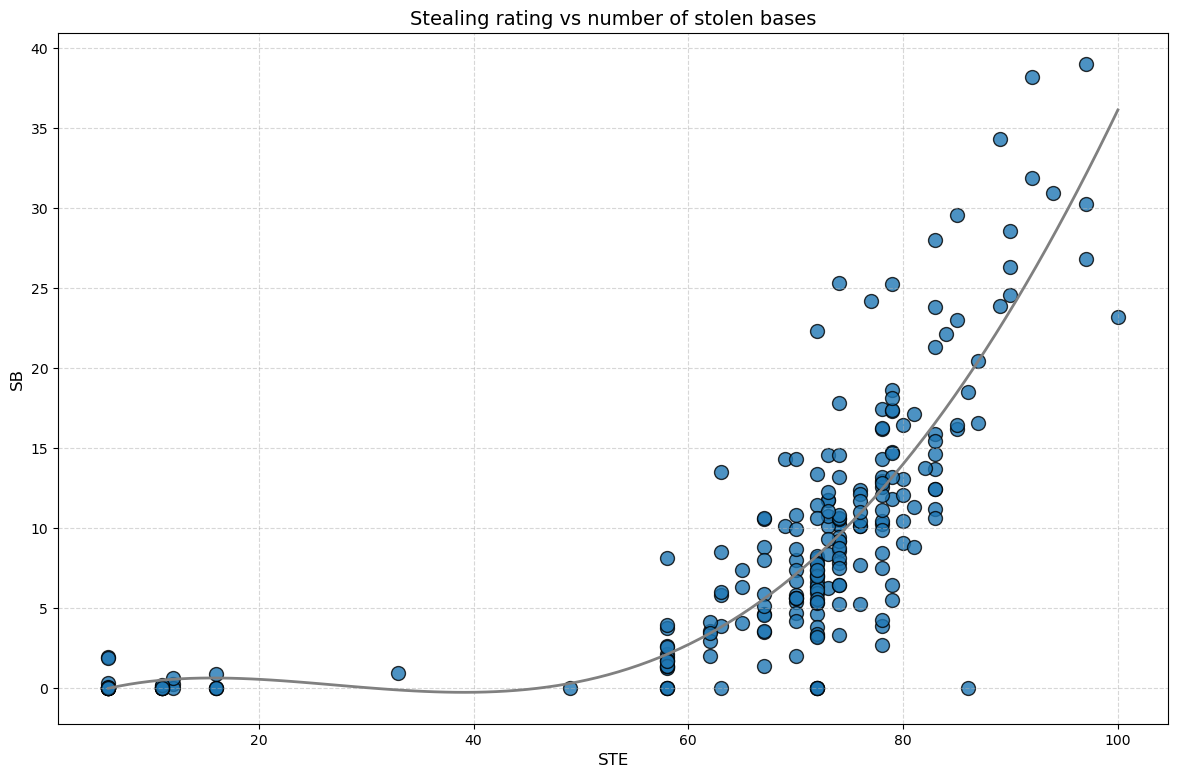

In [54]:
# Remove outliers using IQR method
Qd = df_batters_agg['SB'].astype(float).quantile(0.05)
Qu = df_batters_agg['SB'].astype(float).quantile(0.95)
IQR = Qu - Qd
lower_bound = Qd - 1.5 * IQR # not excluding anything but good to have it for completness
upper_bound = Qu + 1.5 * IQR

# Filter the data to remove outliers
series_sb = np.nan_to_num(df_batters_agg['SB'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)
series_ste = np.nan_to_num(df_batters_agg['STE'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)

plt.figure(figsize=(12, 8))
plt.scatter(series_ste, series_sb, s=100,
            marker='o', edgecolors='black', alpha=0.8)

# Calculate polynomial fit
coefficients = np.polyfit(series_ste, series_sb, 4)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(series_ste), max(series_ste), 100)
y_values = polynomial(x_values)


# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

plt.xlabel('STE', fontsize=12)
plt.ylabel('SB', fontsize=12)
plt.title('Stealing rating vs number of stolen bases', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=1.5)

plt.show()


The relationship between the number of stolen bases and the stealing rating is expoential in nature.

#### Ball type and pitcher's Babip

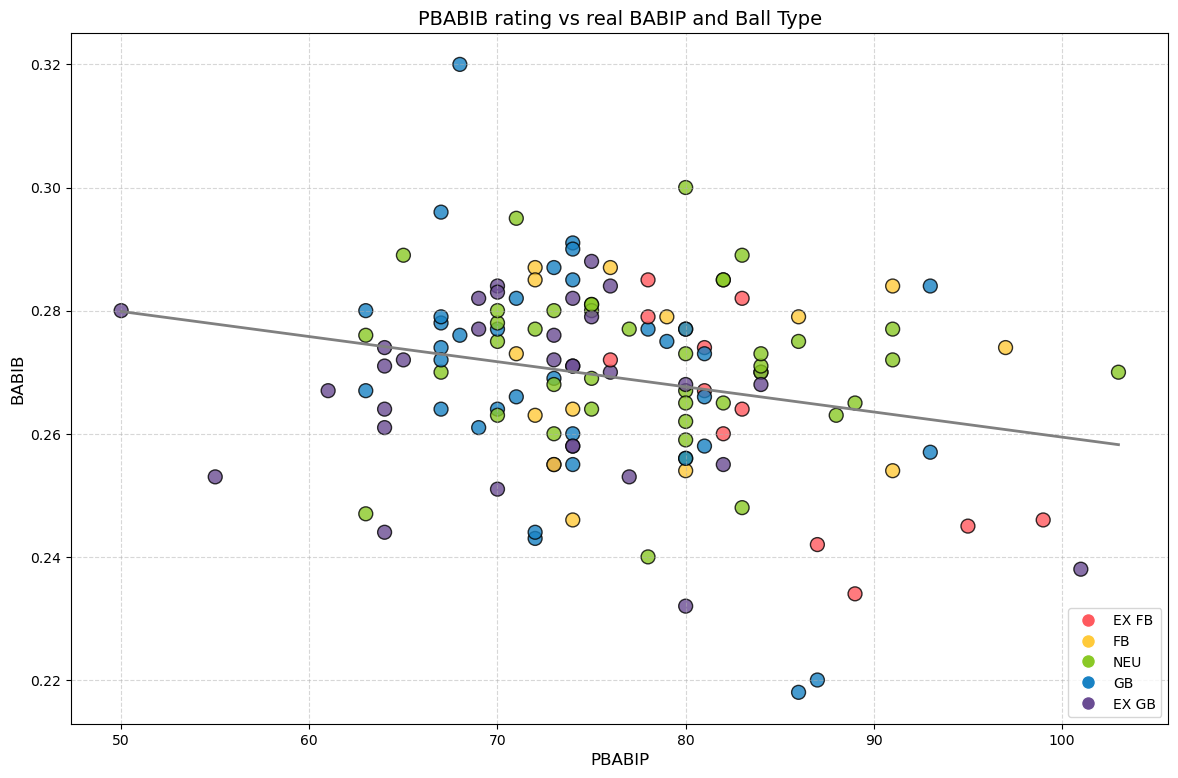

In [55]:
# Does ball type influence pitcher's BABIP?

# Set custom color palette for different 'G/F' categories
colors = {'EX FB': '#FF595E', 'FB': '#FFCA3A', 'NEU': '#8AC926', 'GB': '#1982C4', 'EX GB': '#6A4C93'}
chart_data = df_pitchers_agg[df_pitchers_agg['IP'] > 100]

plt.figure(figsize=(12, 8))

plt.scatter(chart_data['PBABIP'], chart_data['BABIP'], s=100, c=chart_data['G/F'].map(colors),
            marker='o', edgecolors='black', alpha=0.8)

# Fit linear regression
X = sm.add_constant(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0))
model = sm.OLS(np.nan_to_num(chart_data['BABIP'].astype(float), nan=0.0), X)
results = model.fit()
intercept, slope = results.params

x_values = np.linspace(min(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), max(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), 100)
y_values = intercept + slope * x_values

plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

plt.xlabel('PBABIP', fontsize=12)
plt.ylabel('BABIB', fontsize=12)
plt.title('PBABIB rating vs real BABIP and Ball Type', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX FB'], markersize=10, label='EX FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['FB'], markersize=10, label='FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['NEU'], markersize=10, label='NEU'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GB'], markersize=10, label='GB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX GB'], markersize=10, label='EX GB')]
plt.legend(handles=legend_elements, loc='lower right')

# NOTE: ADD OPACITY BASED ON PITCHED INNINGS

plt.tight_layout(pad=1.5)

# Save the plot as an image (optional)
# plt.savefig('scatter_plot_with_trendline.png', dpi=300)

plt.show()


There appears to be no discernible correlation between ball type and actual BABIP.

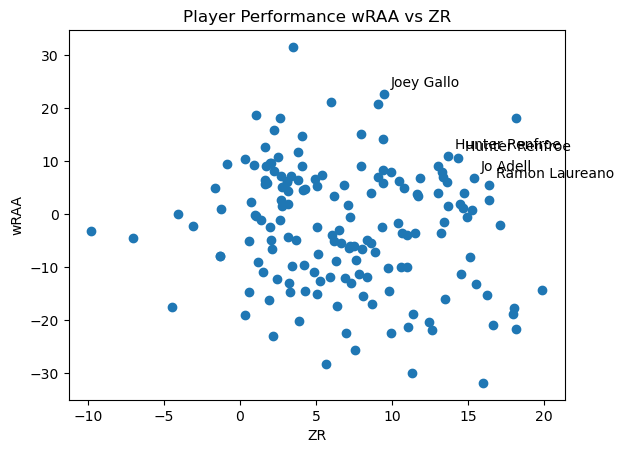

In [56]:
# wRAA vs ZR

# Standardization
def standardize(column):
    mean = np.mean(column)
    std = np.std(column)
    standardized_column = (column - mean) / std
    return standardized_column
# Normalization
def min_max_normalize(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(val - min_val) / (max_val - min_val) for val in column]
    return normalized_column

data = df_batters_agg[(df_batters_agg['PA_WM'] > 500)].copy()
data['ZR'] = data['ZR'].fillna(0).astype(float)
data['wRAA'] = data['wRAA'].fillna(0).astype(float)

# Separate data into x and y coordinates
x = data['ZR']
y = data['wRAA']
names = data['Name']


plt.scatter(x, y)

# Find the indices of the top 5 records in the right-top quadrant
top_records_indices = sorted(range(len(x)), key=lambda i: (standardize(x).iloc[i] + standardize(y).iloc[i]))[-5:]

# Add names to the top records
for index in top_records_indices:
    plt.annotate(names.iloc[index], (x.iloc[index], y.iloc[index]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('ZR')
plt.ylabel('wRAA')
plt.title('Player Performance wRAA vs ZR')

plt.show()


The goal of this chart was to pinpoint players who excel both in ZR and OPS metrics.

## Modeling

Goal of the modeling part has two main objectives:

1. Predicting wRAA for players with insufficient data collected. This entails utilizing the ratings of the players.

2. Predicting wRAA, considering batting splits, to determine the highest potential of each player under ideal conditions. By ideal conditions is considered the most favorable pitcher handedness (from the batter's perspective).

### Predictors prep

In [57]:
# a predictor for batter splittines
df_batters_agg_model = df_batters_agg.copy()
df_batters_agg_model['Split_Ratio'] = (df_batters_agg_model['CON vL'] + df_batters_agg_model['GAP vL'] + df_batters_agg_model['POW vL'] + df_batters_agg_model['EYE vL']) / (df_batters_agg_model['CON vR'] + df_batters_agg_model['GAP vR'] + df_batters_agg_model['POW vR'] + df_batters_agg_model['EYE vR'])

In [58]:
df_batters_agg_model['Reverse_Split'] = 0
df_batters_agg_model.loc[((df_batters_agg_model['B'] == 'Right') & (df_batters_agg_model['Split_Ratio'] < 0.95)) | ((df_batters_agg_model['B'] == 'Left') & (df_batters_agg_model['Split_Ratio'] > 1.05)),'Reverse_Split'] = 1

In [59]:
# categorical predictors into numerical
df_batters_agg_model = pd.get_dummies(df_batters_agg_model, columns=['BBT','GBT','FBT','B'], drop_first=True)

# Dummy Variable Trap -> two or more dummy variables created by one-hot encoding are highly correlated (multi-collinear) -> drop_first=True

# outliers removal 
# 1) remove of players with not enough data collected based on the plate apperarances
df_batters_agg_model = df_batters_agg_model[df_batters_agg_model['PA_WM'] > 500]

In [60]:
df_batters_agg_model

,POS,Name,HT,T,OVR,CON,BABIP,GAP,POW,EYE,K's,BA vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BA vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,C ABI,C FRM,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,SR,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM,wRC_calc,RZBF,Split_Ratio,Reverse_Split,BBT_Normal,GBT_Normal,GBT_Pull,GBT_Spray,FBT_Pull,FBT_Spray,B_Right,B_Switch
7,1B,Bobby Dalbec,"6' 4""",Right,67,62,75,58,79,74,55,77,66,61,83,76,57,75,62,58,79,74,55,47,36,1,1,1,39,43,85,32,40,53,70,80,92,0,80,29,48,20,48,0,43,75,32,78,2115,160.364,154.909,51.15,553.091,140.0,93.091,21.818,4.0,21.091,66.182,62.545,39.636,6.608,0.364,4.727,1.455,2.545,0.0,140.727,23.464,10.545,46.909,233.091,0.254,0.307,0.423,6.726,6.023,0.168,0.32,0.73,101.662,0.3,-0.571,65.091,100.666,1.564,1.236,3.768,17.455,10.909,43.436,1.564,0.291,-0.291,-0.073,169.091,154.909,1344.0,66.182,1272.364,5.455,121.091,0.0,15.585,9.144,2.73,1.006,0.0,0.0,0.0,111.097,0.0,0.0,0.0,95.494,197.753,189.097,78.854,34.623,30.961,46.428,15.98,11.319,26.981,9.988,4.994,4.667,15.647,0.999,8.323,0.0,0.0,99.391,1650,3604.5,110.742,4.494,1.047619,0,1,0,1,0,1,0,1,0
10,1B,Carlos Santana,"5' 11""",Right,68,68,57,61,81,90,84,58,72,61,80,87,94,57,67,62,82,91,81,31,17,20,20,27,35,37,55,26,41,48,63,52,82,3,52,17,25,0,47,0,40,7,14,72,7140,147.938,134.959,56.226,520.917,132.759,84.033,25.188,0.99,22.548,75.674,77.544,69.074,11.514,2.09,5.17,0.0,4.84,0.0,78.533,13.088,16.719,48.726,227.571,0.255,0.345,0.437,7.466,5.745,0.182,0.344,0.782,118.422,0.26,0.513,74.464,118.162,12.704,1.991,3.799,6.929,8.139,31.606,12.704,-0.869,-1.518,-2.354,82.053,69.954,611.879,31.017,579.432,1.43,45.866,0.0,19.989,5.64,1.669,0.639,2.09,0.77,1.28,49.745,0.0,13.977,0.056,61.613,188.38,181.496,47.767,37.134,31.918,24.757,15.855,11.474,8.552,10.639,3.755,1.533,13.977,0.626,5.215,-0.484,0.0,98.222,5455,5752.2,125.035,11.7019,0.993377,0,1,0,0,0,1,0,0,1
11,1B,Cavan Biggio,"6' 2""",Right,69,63,68,66,57,91,62,61,58,63,54,90,60,71,66,67,58,92,63,81,56,0,-,0,67,70,60,58,63,67,55,90,120,0,90,69,61,53,74,40,62,26,23,76,2624,164.273,155.117,54.679,516.517,131.957,97.487,19.928,1.077,13.465,58.169,71.095,71.634,11.931,1.616,5.386,0.539,6.463,0.0,114.722,19.11,7.54,34.47,194.434,0.255,0.348,0.376,6.15,4.663,0.121,0.326,0.724,106.327,0.3,-0.382,63.555,107.581,4.794,1.777,3.983,12.388,20.467,35.913,4.794,-5.009,1.508,-3.609,184.201,155.117,1223.698,76.481,1143.986,3.232,99.641,0.0,15.142,8.104,4.281,1.016,0.0,0.0,0.0,122.379,0.0,0.0,0.0,97.541,202.616,198.335,85.501,34.245,29.964,55.652,13.317,9.512,21.409,9.988,3.329,13.77,20.927,3.805,9.512,0.0,-0.215,95.876,1114,2523.0,114.136,5.8941,0.936396,0,1,0,0,1,0,1,0,0
15,1B,Daniel Vogelbach,"6' 0""",Right,64,63,65,63,78,110,65,57,54,58,72,101,57,69,68,66,81,113,68,17,8,0,-,0,17,34,36,12,7,28,32,36,58,0,36,0,0,0,0,0,0,35,4,6,2646,196.073,129.196,44.006,510.323,130.716,76.377,31.159,1.9,21.279,63.458,67.258,80.177,13.357,4.56,5.32,0.38,4.18,0.0,115.896,19.326,14.82,54.338,229.512,0.256,0.36,0.449,7.098,6.702,0.193,0.354,0.81,128.089,0.294,1.642,76.377,126.338,18.163,2.546,3.989,0.0,0.0,0.0,18.163,0.0,-0.798,-0.798,52.818,34.959,362.888,17.479,344.649,0.76,30.399,0.0,57.078,7.382,2.659,0.489,0.0,0.0,0.0,24.777,0.0,0.0,0.0,45.558,176.823,167.516,33.629,34.567,34.567,15.897,15.954,14.624,6.84,11.965,6.647,0.0,15.954,0.0,2.659,0.0,0.0,100.0,1579,902.6,131.165,20.2899,0.868902,0,1,0,0,1,0,1,0,0
26,1B,Jesse Winker,"6' 3""",Left,69,71,72,60,75,106,70,68,64,58,70,102,64,74,73,61,77,107,72,28,19,0,-,0,20,26,40,14,47,49,51,42,56,0,42,0,0,0,52,12,42,3,5,6,805,175.75,137.575,54.085,504.922,121.729,82.113,25.21,1.441,12.96

In [61]:
# size of sample
len(df_batters_agg_model)

164

In [62]:
predictors_batters = [
    'BABIP', 'CON', 'GAP', 'POW', 'EYE', "K's", 'BA vL', 'CON vL',
    'GAP vL', 'POW vL', 'EYE vL', 'K vL', 'BA vR', 'CON vR', 'GAP vR',
    'POW vR', 'EYE vR', 'K vR', 'BUN', 'BFH', 
    #'BBT_Groundball',
    #'BBT_Line Drive',
    'BBT_Normal', 'GBT_Normal', 'GBT_Pull',
    'GBT_Spray', 'FBT_Pull', 'FBT_Spray','B_Right','B_Switch','Split_Ratio'#,'Reverse_Split'
]

### Correlation

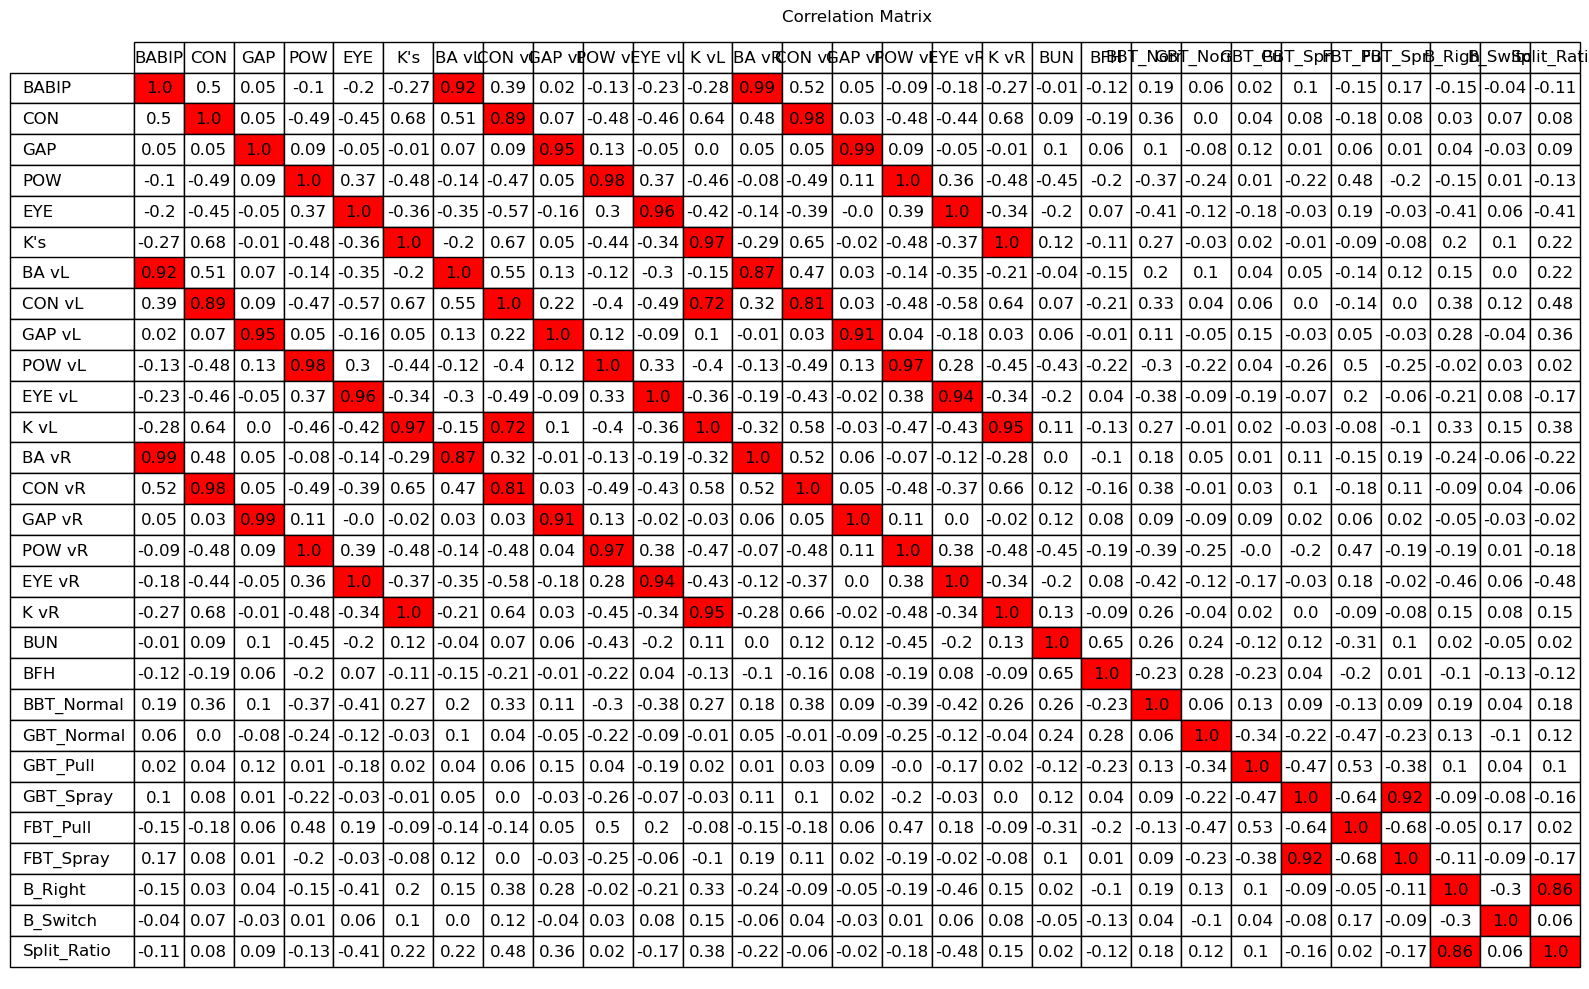

In [63]:
# Correlation matrix
correlation_matrix = df_batters_agg_model[predictors_batters].corr()

fig, ax = plt.subplots(figsize=(16, 10))

table = plt.table(cellText=correlation_matrix.round(2).values,
                  cellColours=np.where(np.abs(correlation_matrix.values) >= 0.7, 'red', 'white'),
                  rowLabels=correlation_matrix.index,
                  colLabels=correlation_matrix.columns,
                  cellLoc='center',
                  loc='center')

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

ax.axis('off')

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [64]:
# Function to get correlated pairs from the matrix
def get_correlated_pairs(correlation_matrix, threshold):
    pairs = []
    n = correlation_matrix.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:
                pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation)
                pairs.append(pair)

    return pairs

In [65]:
threshold = 0.8  # Correlation threshold
correlated_pairs = get_correlated_pairs(correlation_matrix, threshold)

for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

BABIP - BA vL: 0.9232397190592412
BABIP - BA vR: 0.9910649089726311
CON - CON vL: 0.8913151848735059
CON - CON vR: 0.9849791619992418
GAP - GAP vL: 0.9512359868769718
GAP - GAP vR: 0.9918088229697484
POW - POW vL: 0.9843281611900976
POW - POW vR: 0.9984421455773564
EYE - EYE vL: 0.9591638648106089
EYE - EYE vR: 0.9968099917582226
K's - K vL: 0.9734912890882218
K's - K vR: 0.9964384438167164
BA vL - BA vR: 0.8672546185358563
CON vL - CON vR: 0.8099440940696776
GAP vL - GAP vR: 0.907505209617669
POW vL - POW vR: 0.9736300713832213
EYE vL - EYE vR: 0.9350478570772679
K vL - K vR: 0.951890528108525
GBT_Spray - FBT_Spray: 0.9178146529232246
B_Right - Split_Ratio: 0.8566082151194343


In [66]:
# Removal of correlated predictors
for element in ['BA vL', 'BA vR','CON','CON vL','CON vR','GAP vL','GAP vR','EYE vL','EYE vR','POW vL','POW vR','K vL','K vR','BFH']:
    predictors_batters.remove(element)

<Axes: >

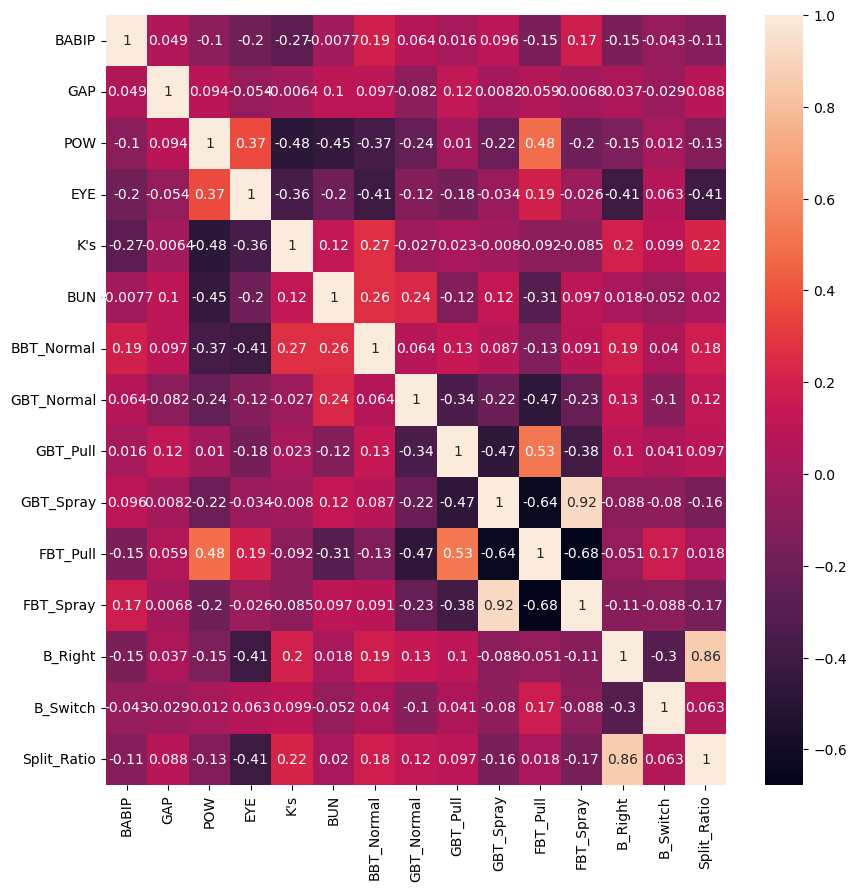

In [67]:
# Heatmap after removing correlated predictors
plt.figure(figsize = (10, 10))
sns.heatmap(df_batters_agg_model[predictors_batters].corr(), annot = True)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_batters_agg_model[predictors_batters].astype(float).dropna()
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)
# note: VIF under 5 is fine

        feature         VIF
0         BABIP  119.534148
1           GAP   48.762366
2           POW   27.601104
3           EYE   52.127294
4           K's   71.390493
5           BUN   18.435610
6    BBT_Normal   61.453664
7    GBT_Normal    8.916902
8      GBT_Pull    3.920614
9     GBT_Spray   10.586437
10     FBT_Pull   32.004053
11    FBT_Spray   19.005263
12      B_Right    9.722991
13     B_Switch    1.561302
14  Split_Ratio  611.333210


In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [70]:
# predictors and a target variable
X = df_batters_agg_model[predictors_batters].astype('float64')
y = df_batters_agg_model['wRAA'].astype('float64')

# Handle missing values
X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

# # Add a column of ones as the constant term to the predictor matrix
# X = np.append(arr=np.ones((X.shape[0], 1)), values=X, axis=1)

## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Size of train sample: " + str(len(X_train)))
print("Size of test sample: " + str(len(X_test)))

Size of train sample: 131
Size of test sample: 33


### Backward OLS elimination

In [71]:
def backward_elimination(pred, dep, pn, significance_level=0.05):
    num_predictors = pred.shape[1]
    for i in range(num_predictors):
        regressor_OLS = sm.OLS(dep, pred).fit()
        max_pvalue = max(regressor_OLS.pvalues).astype(float)
        if max_pvalue > significance_level:
            for j in range(num_predictors - i):
                if regressor_OLS.pvalues[j].astype(float) == max_pvalue:
                    pred = np.delete(pred, j, 1)
                    del pn[j-1] # -1 because there's an extra constant
    regressor_OLS.summary()
    return pred, pn

In [72]:
pred_names = predictors_batters.copy()

# Addition of intercept (a column of ones)
X_trn_ols = sm.add_constant(X_train)
X_tst_ols = sm.add_constant(X_test,has_constant='add') # NOTE: add_constant() doesn't works if there is already a column with variance=0

# Perform backward elimination
XPN = backward_elimination(X_trn_ols, y_train, pred_names, 0.1)
X_trn_ols = XPN[0]
pred_names = XPN[1]

# Fit the final model
regressor = sm.OLS(y_train, X_trn_ols).fit()

# Print the summary of the final model
print(regressor.summary())
print("Predictor names:", pred_names, sep="\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     38.13
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           2.83e-31
Time:                        07:06:09   Log-Likelihood:                -418.23
No. Observations:                 131   AIC:                             856.5
Df Residuals:                     121   BIC:                             885.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -139.4301     21.030     -6.630      0.0

In [73]:
# notes: kurtosis is over 4 -> distribution is too peaked, J-B -> non-normality of residuals

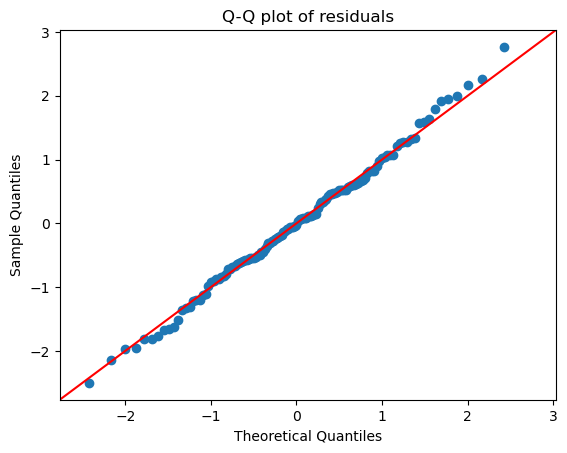

In [74]:
# check for normality of residuals
residuals = regressor.resid

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q plot of residuals")
plt.show()

In [75]:
pred_names

['BABIP',
 'GAP',
 'POW',
 'EYE',
 "K's",
 'BBT_Normal',
 'GBT_Normal',
 'B_Right',
 'Split_Ratio']

In [76]:
# Create a dictionary to map index labels to positions
position_dict = {label: position for position, label in enumerate(predictors_batters)}

# Retrieve positions of columns from the dictionary
column_positions = [position_dict[column] + 1 for column in pred_names]
column_positions = np.insert(column_positions, 0, 0)

# Apply results of backward elimination to test sample
X_test_be = X_tst_ols[:, column_positions]

In [77]:
from sklearn.metrics import mean_squared_log_error, r2_score

# Make predictions on the testing data
y_pred = regressor.predict(X_test_be)

# RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
# print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The R2 score is 31.88%


In [78]:
# Sample is extremely small -> cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Cross-validation
scores = cross_val_score(LinearRegression(), X_trn_ols, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.71197638 0.65755648 0.79716147 0.67054863 0.56345857]
Mean score: 0.6801403050974272


### XGBoost

In [79]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [80]:
def grid_search_cv(X, y, ts, cvn):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

    rf = RandomForestRegressor()

    # Define hyperparameters grid for tuning
    param_grid = {
        'n_estimators': [25, 50, 100, 150, 200], #5,10, 
        'max_depth': [3,4,5, 6,7], # none, 10 
        'min_samples_split': [ 10, 15, 20],
        'min_samples_leaf': [ 10, 15, 20],
        'bootstrap': [True] # False
        # overfitting: n_estimators up, max_depth down, min_samples_split up, bootstrap true, oob_score true, ccp_alpha?
        
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=cvn, n_jobs=-1, verbose=2, scoring='r2')

    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)

    best_rf = grid_search.best_estimator_

    # Evaluate
    #full_score = best_rf.score(X, y)
    #print("Full R^2 Score:", full_score)

    train_score = best_rf.score(X_train, y_train)
    print("Train R^2 Score:", train_score)

    test_score = best_rf.score(X_test, y_test)
    print("Test R^2 Score:", test_score)

    return best_rf

In [81]:
# predictors and a target variable
X = df_batters_agg_model[predictors_batters].astype('float64')
y = df_batters_agg_model['wRAA'].astype('float64')

# Handle missing values
#X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
#y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

In [82]:
best_rf = grid_search_cv(X, y, 0.2, 4)

Fitting 4 folds for each of 225 candidates, totalling 900 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 50}
Train R^2 Score: 0.7127943004297888
Test R^2 Score: 0.35664638297462614


In [83]:
# selected predictors
# best_rf = grid_search_cv(X[pred_names], y, 0.4, 3) 

In [84]:
# Cross-validation
scores = cross_val_score(best_rf, X, y, cv=3)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.52481881 0.38948242 0.72141513]
Mean score: 0.5452387877424728


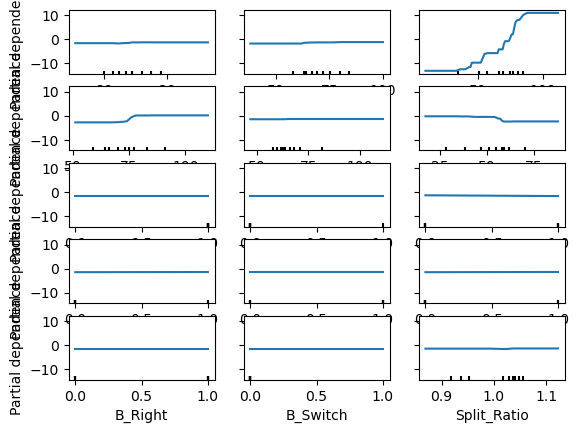

In [85]:
# How does each feature affect the output? 
# Partial Dependence Plots

from sklearn.inspection import PartialDependenceDisplay

display = PartialDependenceDisplay.from_estimator(best_rf, X, list(range(0,X.shape[1])))


In [86]:
# XGBRFRegressor (random forest)
xgb_model = xgb.XGBRFRegressor(objective ='reg:squarederror') # , colsample_bytree=0.2, learning_rate = 0.2, max_depth=5, alpha=5, n_estimators=40

# Fit the model to the training data
xgb_model.fit(X, y)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [87]:
# Cross-validation
scores = cross_val_score(xgb_model, X, y, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.46692343 0.48986367 0.11836119 0.60725883 0.76005139]
Mean score: 0.4884917026113912


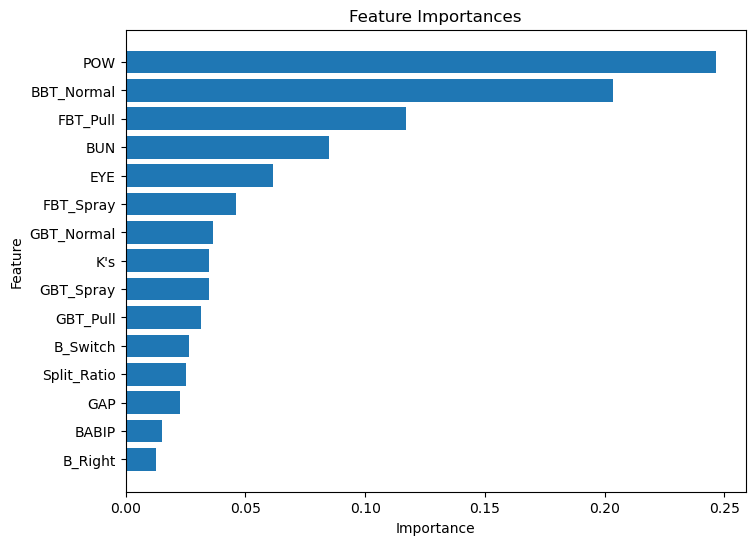

In [88]:
# Get feature importances
importance = xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [89]:
feature_importances

,Feature,Importance
12,B_Right,0.012830
0,BABIP,0.015196
1,GAP,0.022882
14,Split_Ratio,0.025373
13,B_Switch,0.026360
8,GBT_Pull,0.031603
9,GBT_Spray,0.034737
4,K's,0.034772
7,GBT_Normal,0.036636
11,FBT_Spray,0.046189


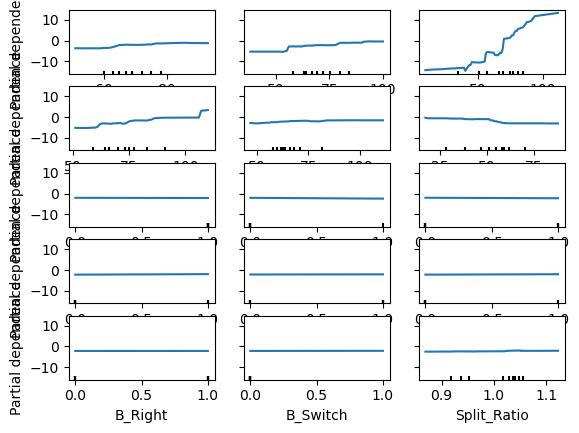

In [90]:
PartialDependenceDisplay.from_estimator(xgb_model, X, list(range(0,X.shape[1])))

### Prediction

In [91]:
# a predictor for batter splittines
df_batters_agg['Split_Ratio'] = (df_batters_agg['CON vL'] + df_batters_agg['GAP vL'] + df_batters_agg['POW vL'] + df_batters_agg['EYE vL']) / (df_batters_agg['CON vR'] + df_batters_agg['GAP vR'] + df_batters_agg['POW vR'] + df_batters_agg['EYE vR'])

In [92]:
df_batters_agg['Reverse_Split'] = 0
df_batters_agg.loc[((df_batters_agg['B'] == 'Right') & (df_batters_agg['Split_Ratio'] < 0.95)) | ((df_batters_agg['B'] == 'Left') & (df_batters_agg['Split_Ratio'] > 1.05)),'Reverse_Split'] = 1

In [93]:
# Predict wRAA
# categorical predictors into numerical
df_batters_agg = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT','B'], drop_first=True)

# a predictor for batter splittines
df_batters_agg['Split_Ratio'] = (df_batters_agg['BA vL'] + df_batters_agg['GAP vL'] + df_batters_agg['POW vL'] + df_batters_agg['EYE vL'] + df_batters_agg['K vL']) / (df_batters_agg['BA vR'] + df_batters_agg['GAP vR'] + df_batters_agg['POW vR'] + df_batters_agg['EYE vR'] + df_batters_agg['K vR'])

In [94]:
df_batters_agg['wRAA_pred'] = xgb_model.predict(df_batters_agg[predictors_batters])

In [95]:
df_batters_agg['wRAA_pred_R'] = xgb_model.predict(df_batters_agg.rename(columns={#'BABIP':'BABIP OR',
'GAP':'GAP OR',
'POW':'POW OR',
'EYE':'EYE OR',
"K's":'K OR',
'BABIP vR':'BABIP',
'GAP vR':'GAP',
'POW vR':'POW',
'EYE vR':'EYE',
"K vR":"K's"})[predictors_batters])


In [96]:
df_batters_agg['wRAA_pred_L'] = xgb_model.predict(df_batters_agg.rename(columns={#'BABIP':'BABIP OR',
'GAP':'GAP OR',
'POW':'POW OR',
'EYE':'EYE OR',
"K's":'K OR',
'BABIP vL':'BABIP',
'GAP vL':'GAP',
'POW vL':'POW',
'EYE vL':'EYE',
"K vL":"K's"})[predictors_batters])


In [97]:
df_batters_agg[df_batters_agg['POS'] != 'XF'].sort_values('wRAA_pred_L', ascending = False)[['Name','B_Right','CON','GAP','POW','EYE','wRAA_pred','wRAA_pred_L','wRAA_pred_R']].drop_duplicates().head(10)

,Name,B_Right,CON,GAP,POW,EYE,wRAA_pred,wRAA_pred_L,wRAA_pred_R
294,Joey Gallo,0,52,64,112,107,23.944380,16.049915,23.394884
198,Gary Sanchez,1,57,64,94,76,14.662415,15.676972,14.470606
299,Rhys Hoskins,1,64,73,88,86,15.616326,15.648565,12.375839
166,Miguel Sano,1,61,68,91,78,10.577021,12.472476,10.480515
329,Jordan Luplow,1,58,67,79,82,3.747517,10.890859,3.606900
36,Luken Baker,1,61,64,87,74,9.288237,10.499048,9.191716
216,Shea Langeliers,1,59,69,91,64,7.378971,10.309164,7.378971
28,Jon Singleton,0,61,57,76,103,3.489081,9.946251,2.117611
170,Nick Castellanos,1,71,75,82,64,7.934195,9.609614,7.686657
386,Hunter Renfroe,1,67,80,79,75,7.444013,8.888450,5.863672


In [98]:
df_batters_agg[df_batters_agg['POS'] != 'XF'].sort_values('wRAA_pred_R', ascending = False)[['Name','B_Right','CON','GAP','POW','EYE','wRAA_pred','wRAA_pred_L','wRAA_pred_R']].drop_duplicates().head(10)

,Name,B_Right,CON,GAP,POW,EYE,wRAA_pred,wRAA_pred_L,wRAA_pred_R
294,Joey Gallo,0,52,64,112,107,23.944380,16.049915,23.394884
15,Daniel Vogelbach,0,63,63,78,110,15.147288,1.190990,15.677631
292,Gary Sanchez,1,57,64,94,76,14.662415,15.676972,14.470606
50,Rhys Hoskins,1,64,73,88,86,15.616326,15.648565,12.375839
288,Carlos Santana,0,68,61,81,90,11.736884,8.053096,11.876640
26,Jesse Winker,0,71,60,75,106,2.898834,1.931567,10.577187
402,Miguel Sano,1,61,68,91,78,10.577021,12.472476,10.480515
24,Jake Bauers,0,61,71,79,86,7.305323,3.038429,9.796329
54,Ryan O'Hearn,0,71,62,85,66,7.473848,5.638619,9.347637
36,Luken Baker,1,61,64,87,74,9.288237,10.499048,9.191716


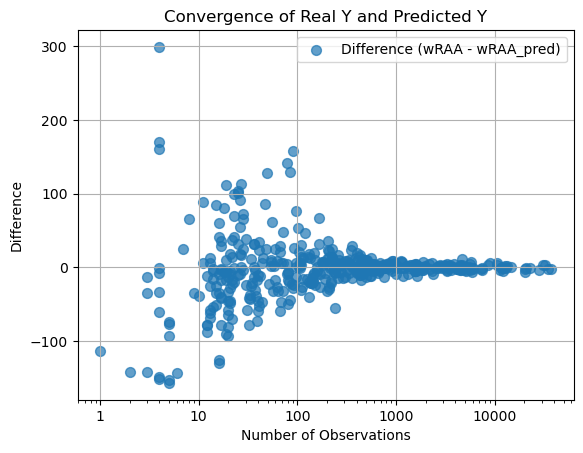

In [99]:
from matplotlib.ticker import ScalarFormatter

def plot_convergence(observations, wRAA, wRAA_pred):
    differences = np.array(wRAA) - np.array(wRAA_pred)

    plt.scatter(observations, differences, s=50, alpha=0.7, label='Difference (wRAA - wRAA_pred)')

    plt.xlabel('Number of Observations')
    plt.ylabel('Difference')
    plt.title('Convergence of Real Y and Predicted Y')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set logarithmic scale for the x-axis
    #plt.xlim(1, 10000)  # Set x-axis limits
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.show()


plot_convergence( df_batters_agg['PA_WM'], df_batters_agg['wRAA'], df_batters_agg['wRAA_pred'])


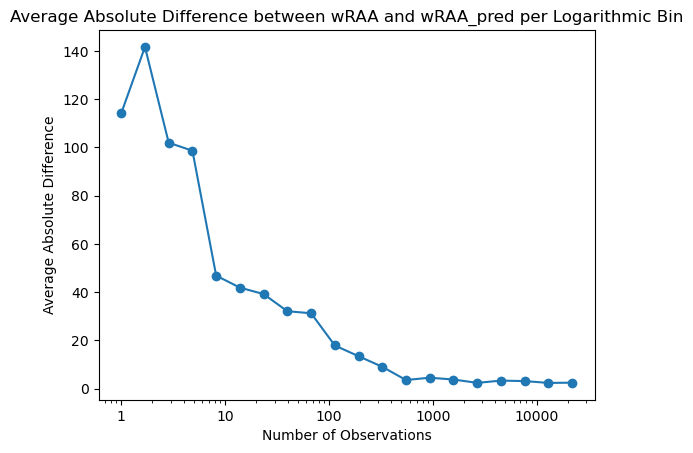

In [100]:
observations = df_batters_agg['PA_WM']
wRAA = df_batters_agg['wRAA']
wRAA_pred = df_batters_agg['wRAA_pred']

# Calculate the absolute differences between ops and ops_pred
differences = np.abs(np.array(wRAA) - np.array(wRAA_pred))

# Calculate the logarithmic bins
log_bins = np.logspace(np.log10(1), np.log10(max(observations)),num=21)

# Calculate the bin indices for each observation
bin_indices = np.digitize(observations, log_bins)

# Calculate the average absolute differences for each bin
bin_averages = [np.mean(differences[bin_indices == i]) for i in range(1, len(log_bins))]


fig, ax = plt.subplots()
ax.plot(log_bins[:-1], bin_averages, 'o-')

ax.set_xscale('log')
ax.set_xlabel('Number of Observations')
ax.set_ylabel('Average Absolute Difference')
ax.set_title('Average Absolute Difference between wRAA and wRAA_pred per Logarithmic Bin')

# Set full number format for x-axis ticks
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.show()

# Conclusion

This is the third version of the analysis, primarily incorporating new ratings added by the game developer (OOTP24 vs OOTP25). The overall results and conclusions remain nearly identical to previous versions, suggesting that the game engine has not been significantly altered between the years, despite the addition of new ratings.